In [1]:
import torch
import numpy as np
import lmdb

In [2]:
def extract(value):
    # print(value.shape)
    data = value.reshape([-1, 17, 28, 28])
    data = data.transpose([1, 0, 2, 3])
    # data = data[[0, 4, 8, 12, 16]]
    return data

In [3]:
from matplotlib import pyplot as plt

(1, 17, 28, 28)
(17, 1, 28, 28)


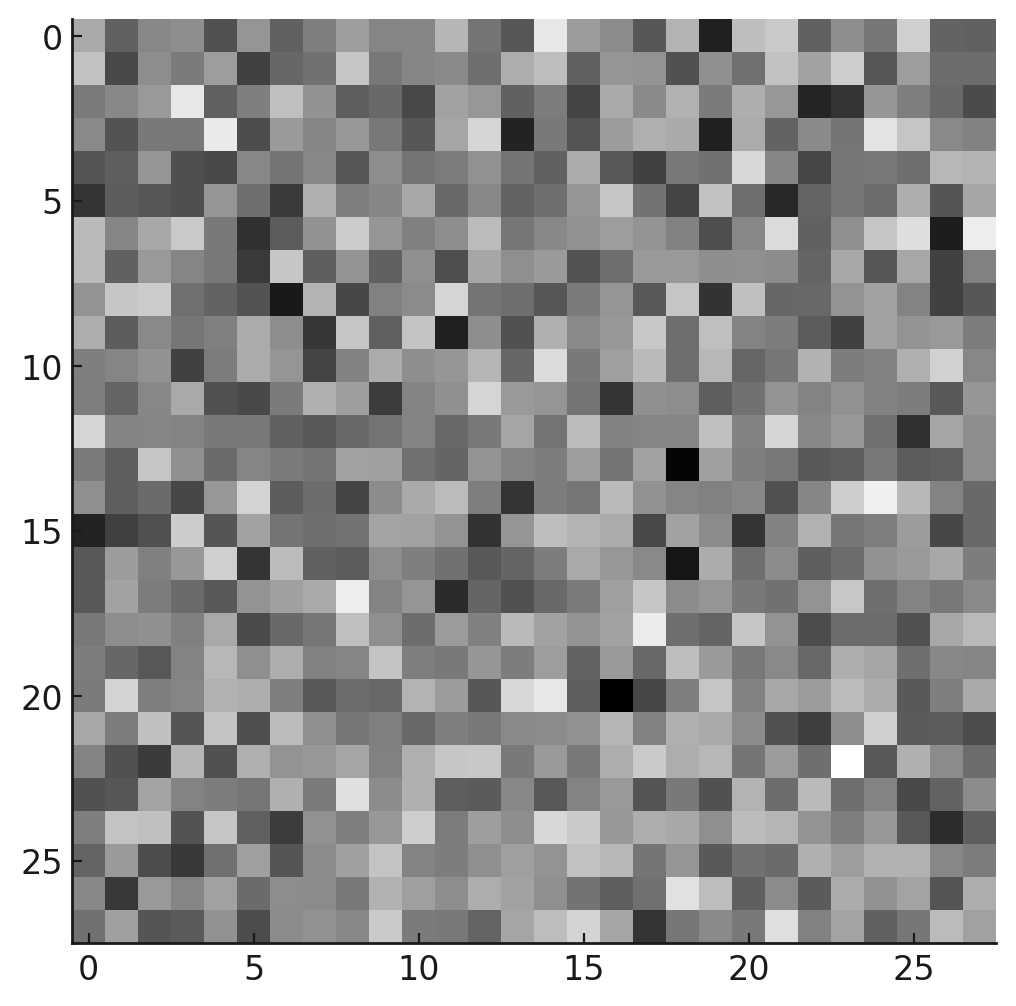

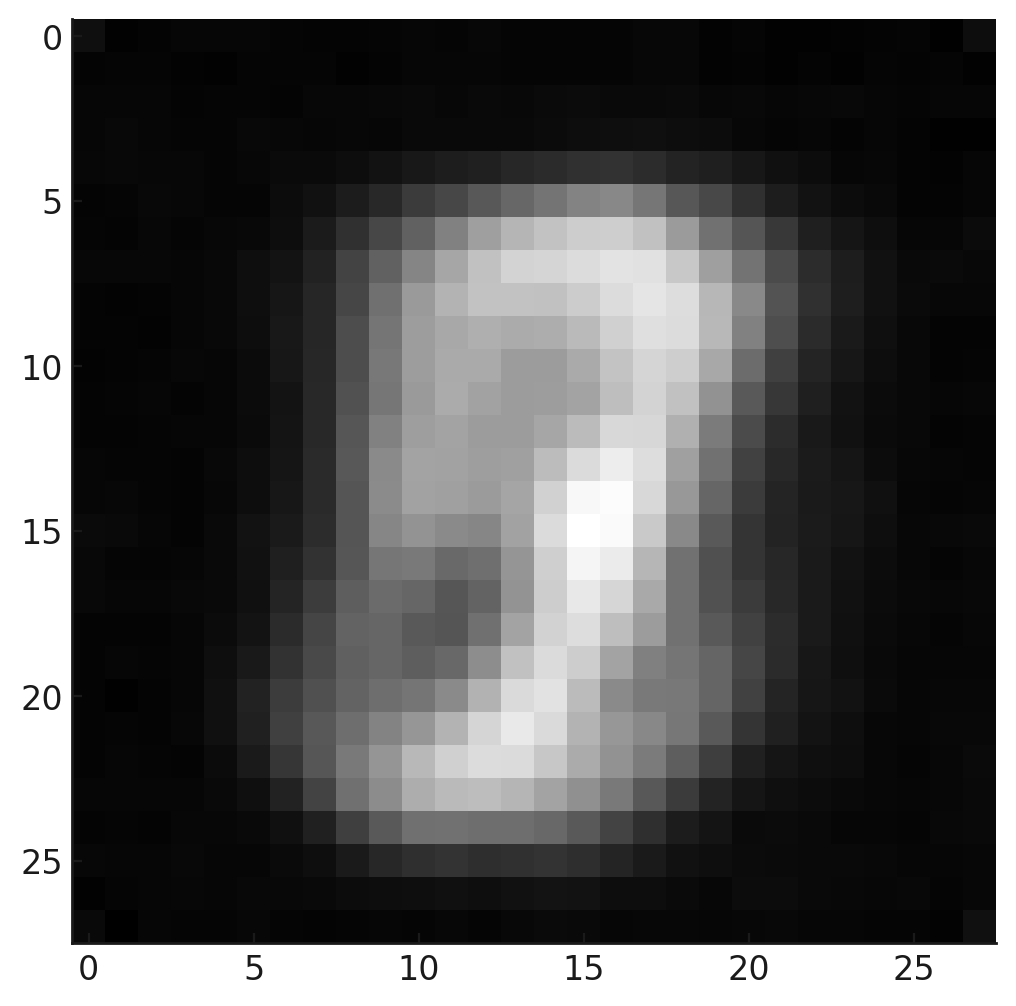

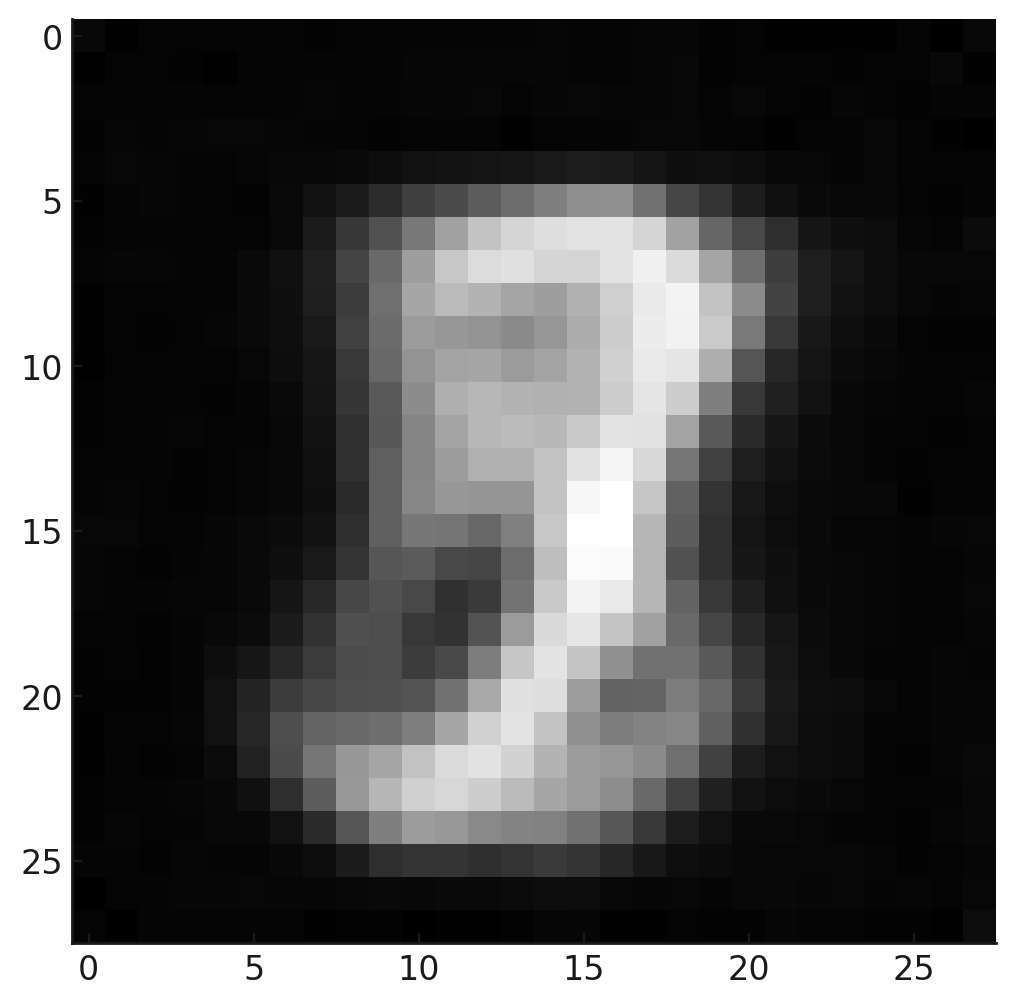

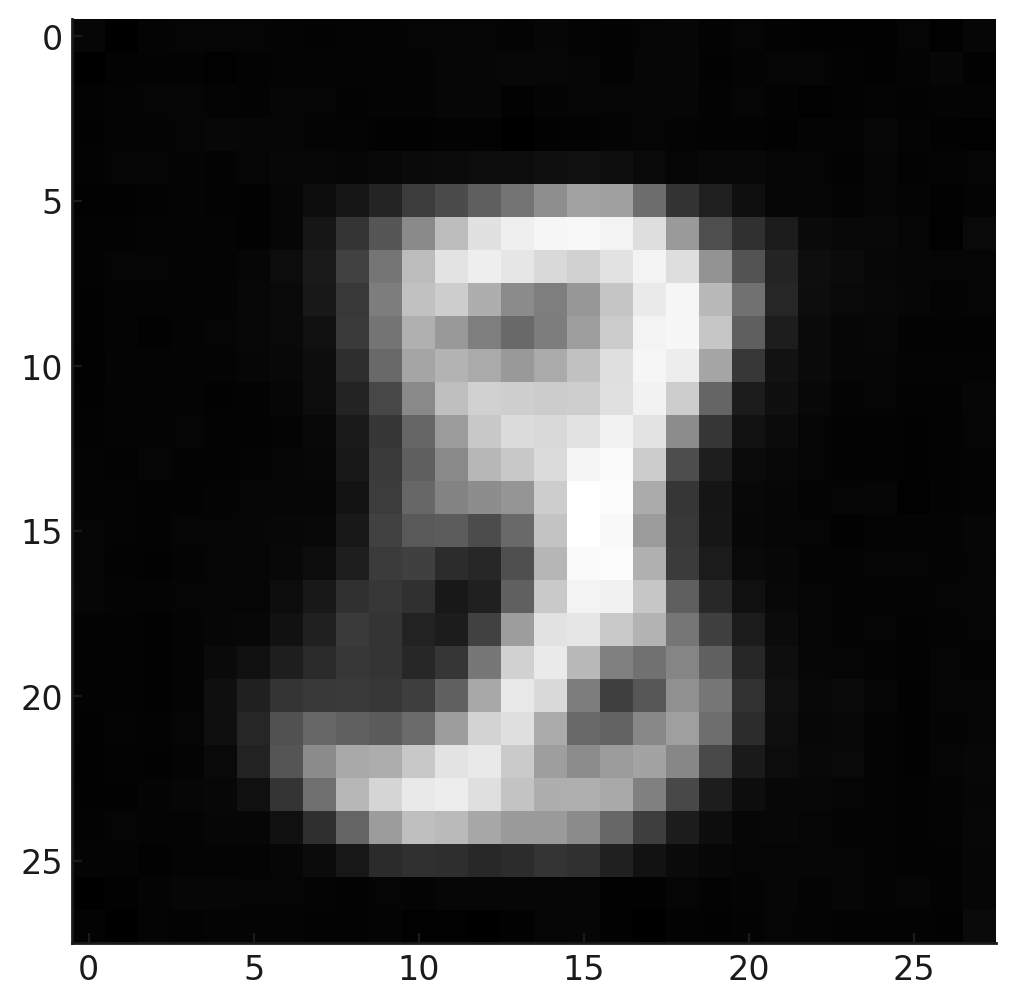

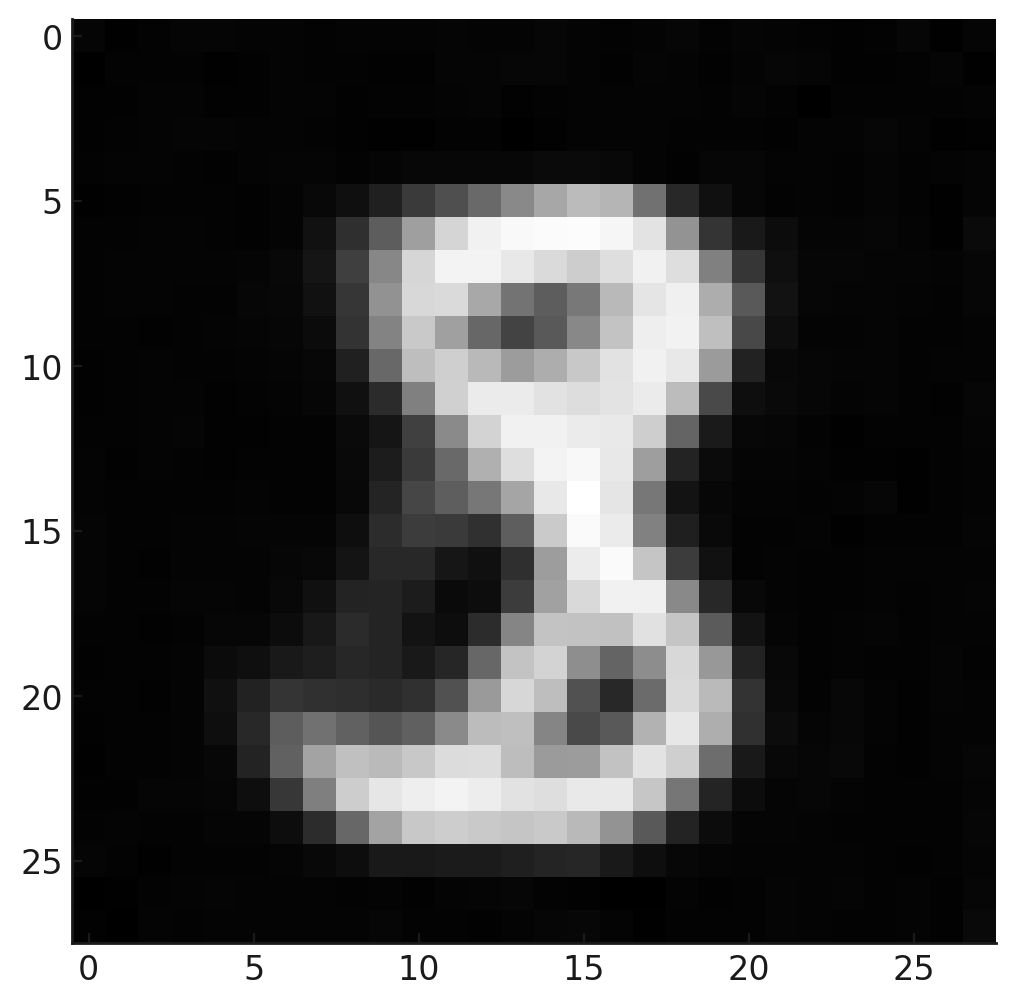

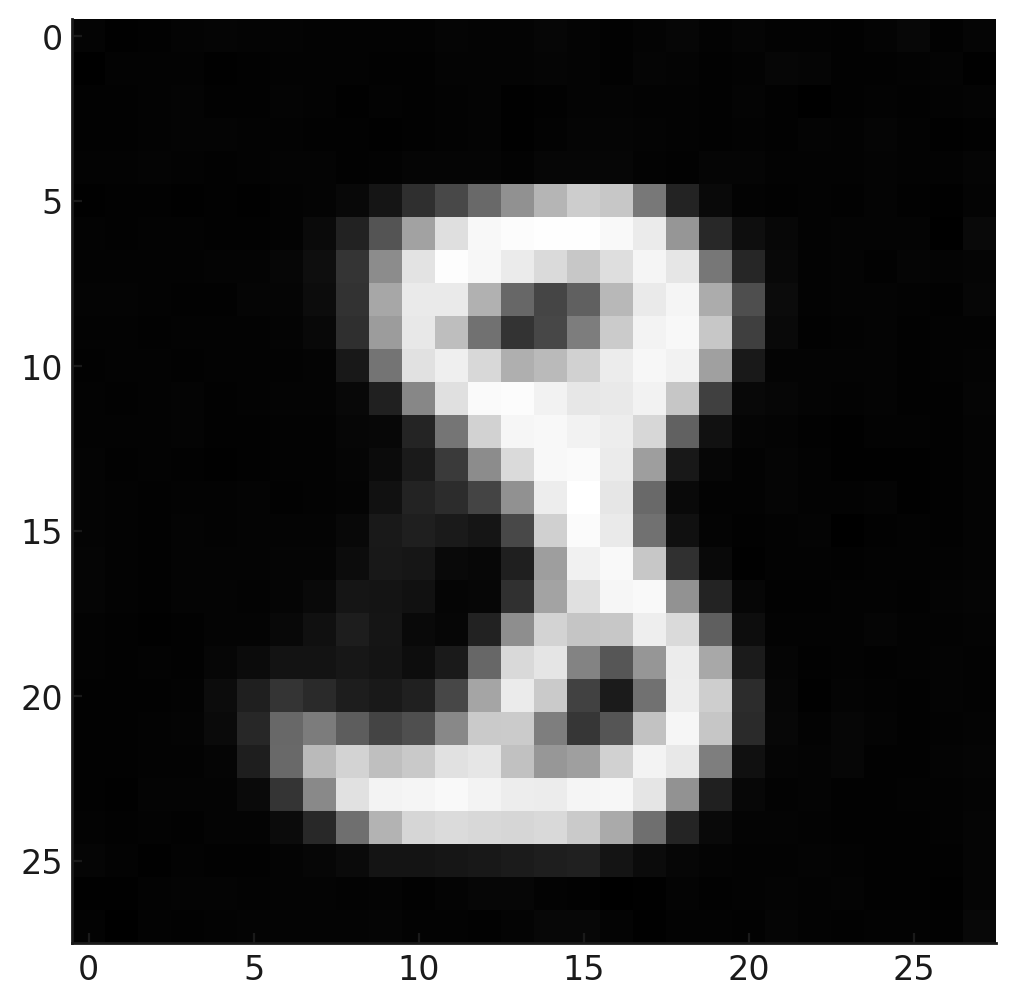

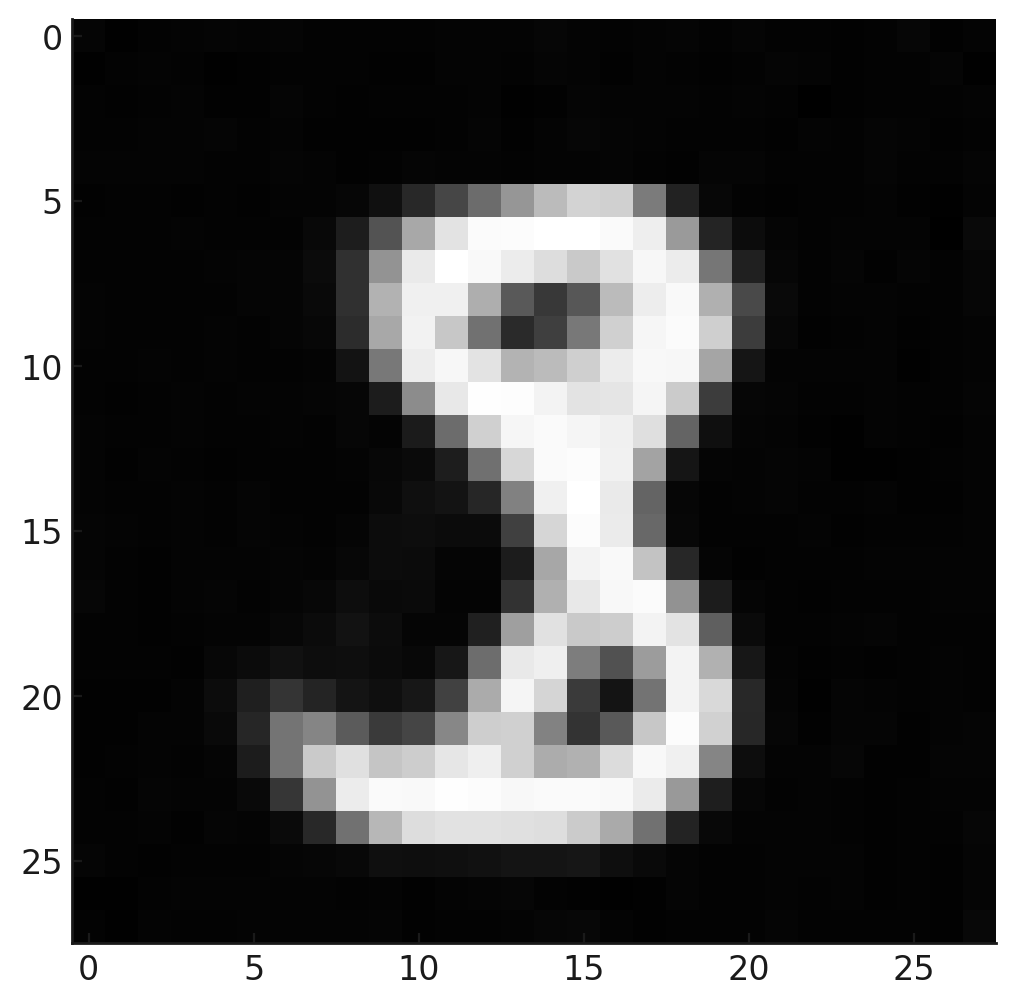

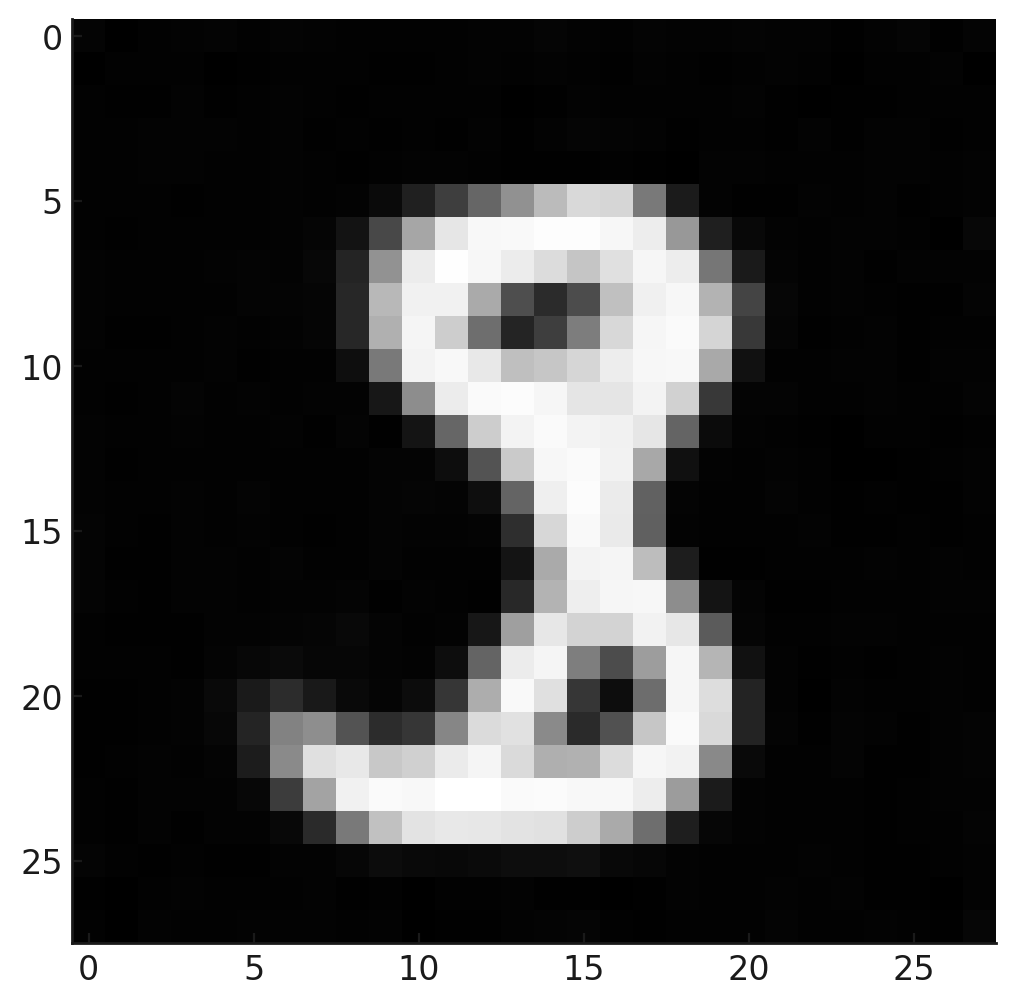

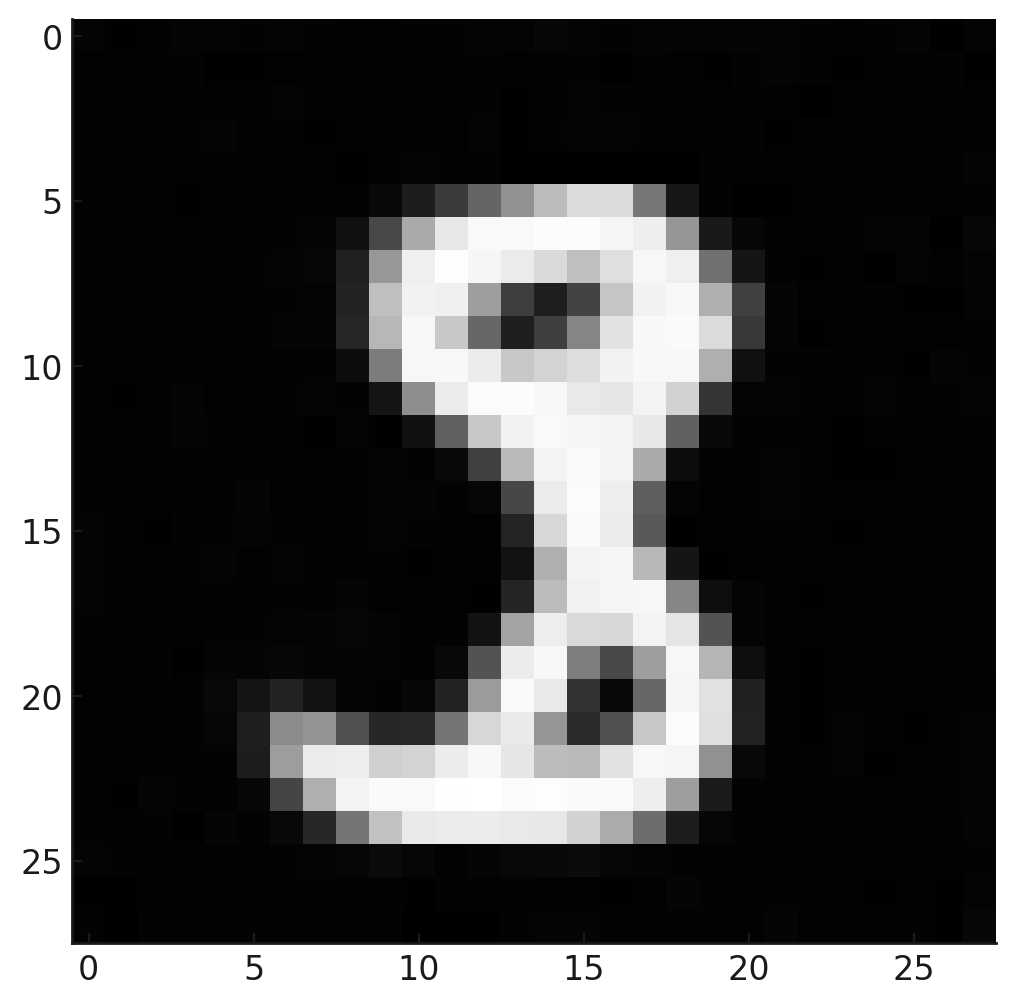

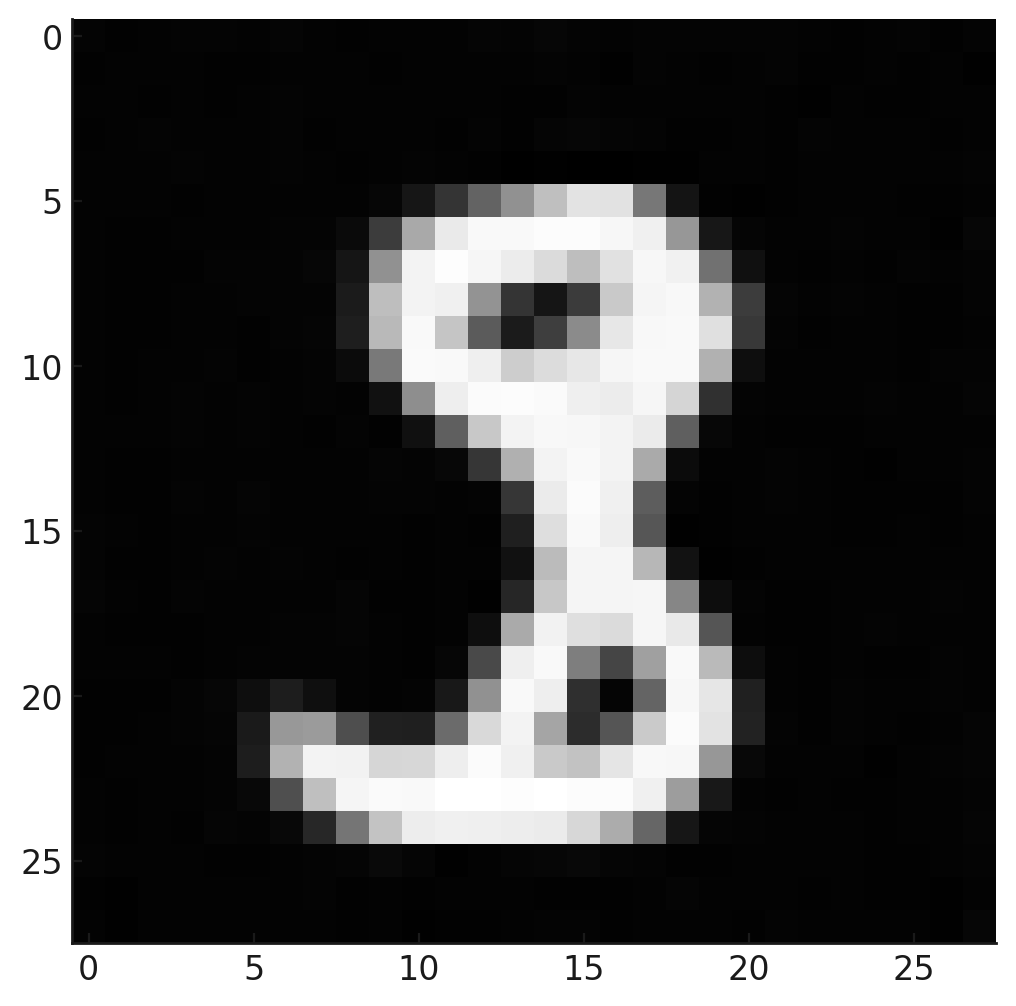

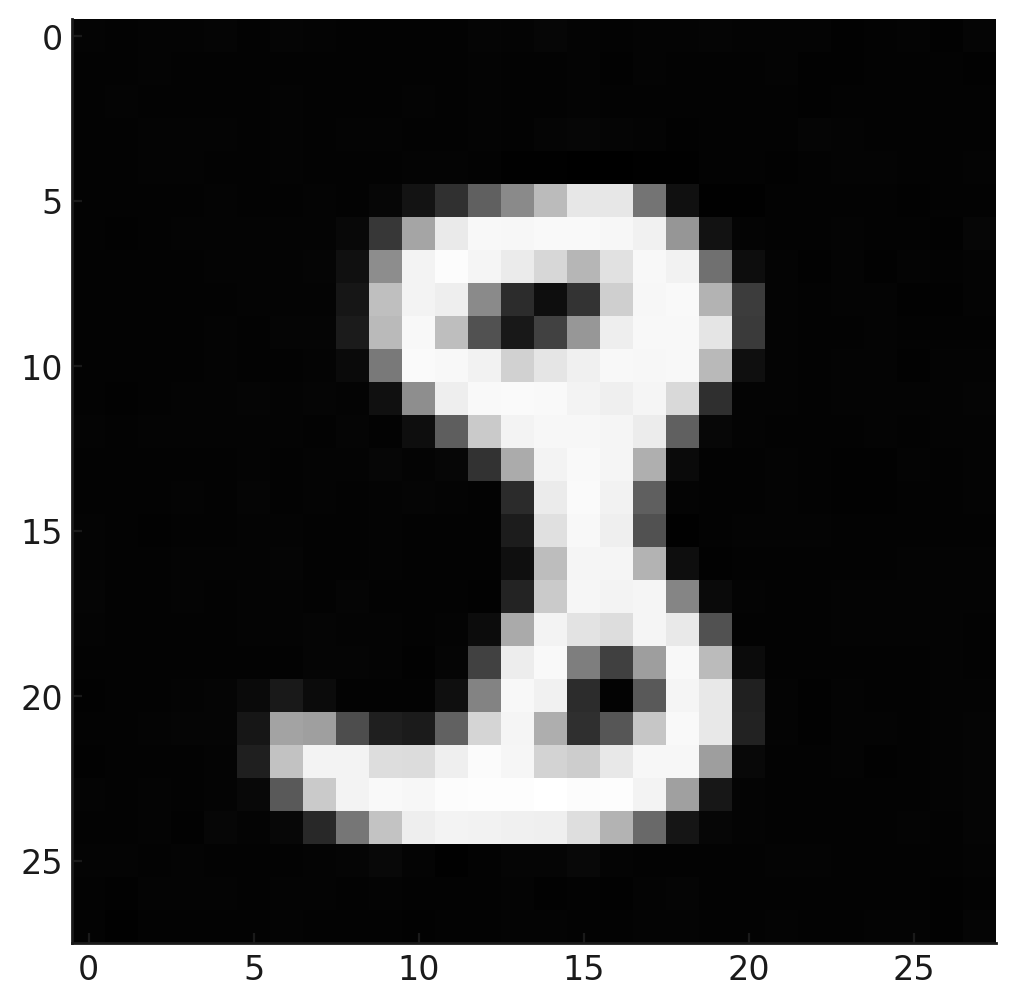

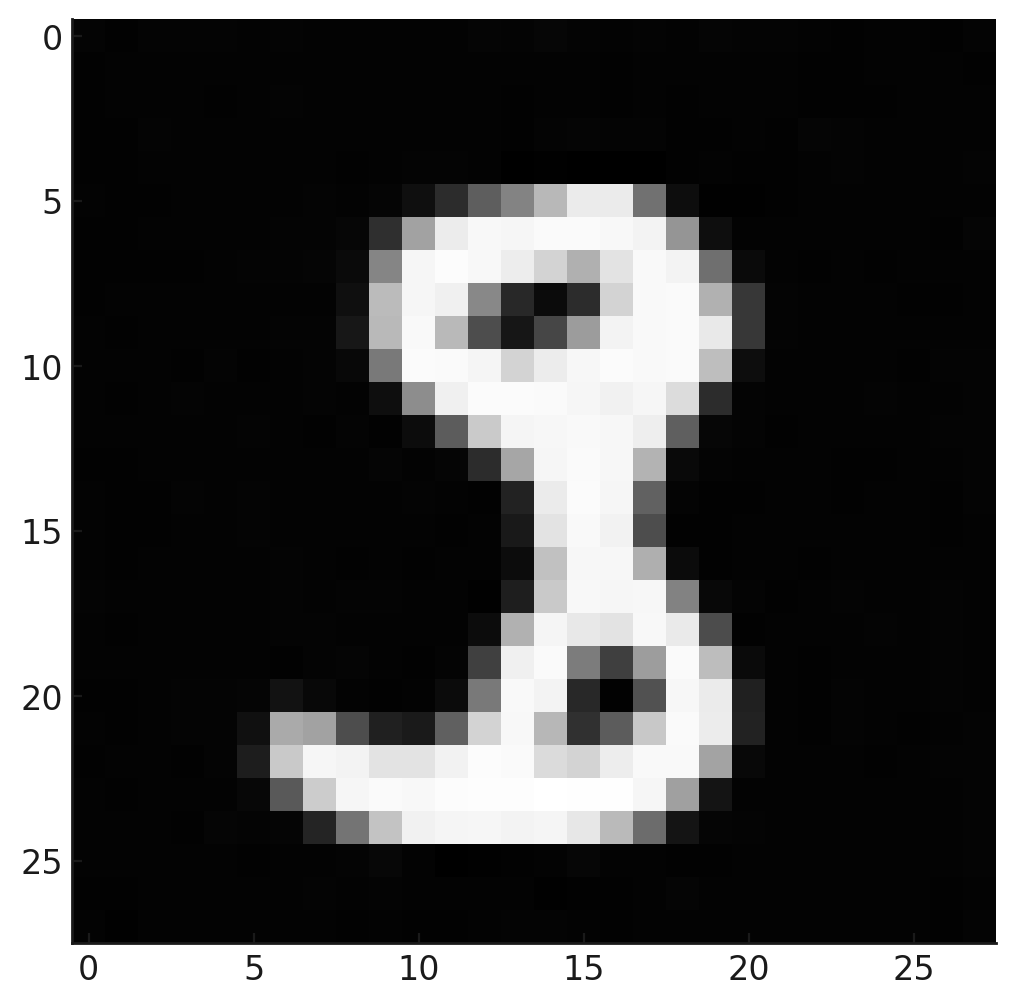

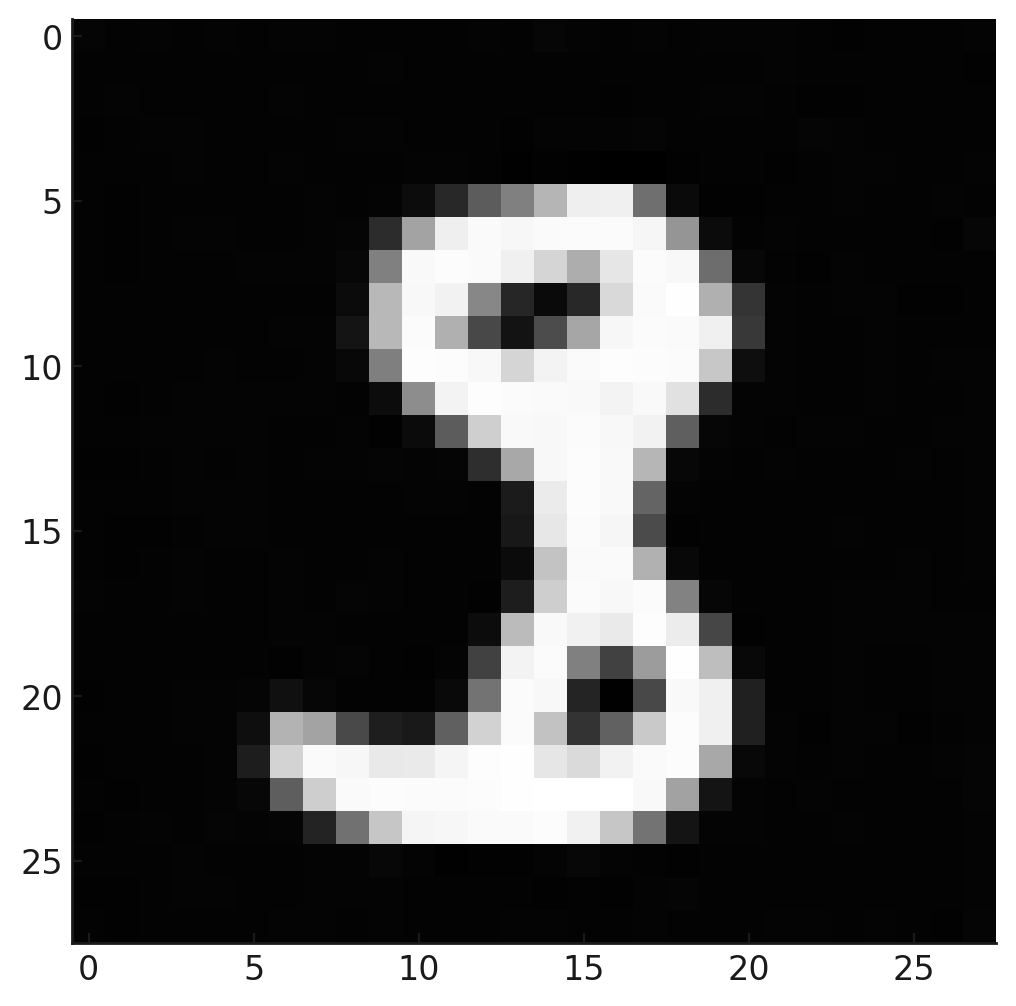

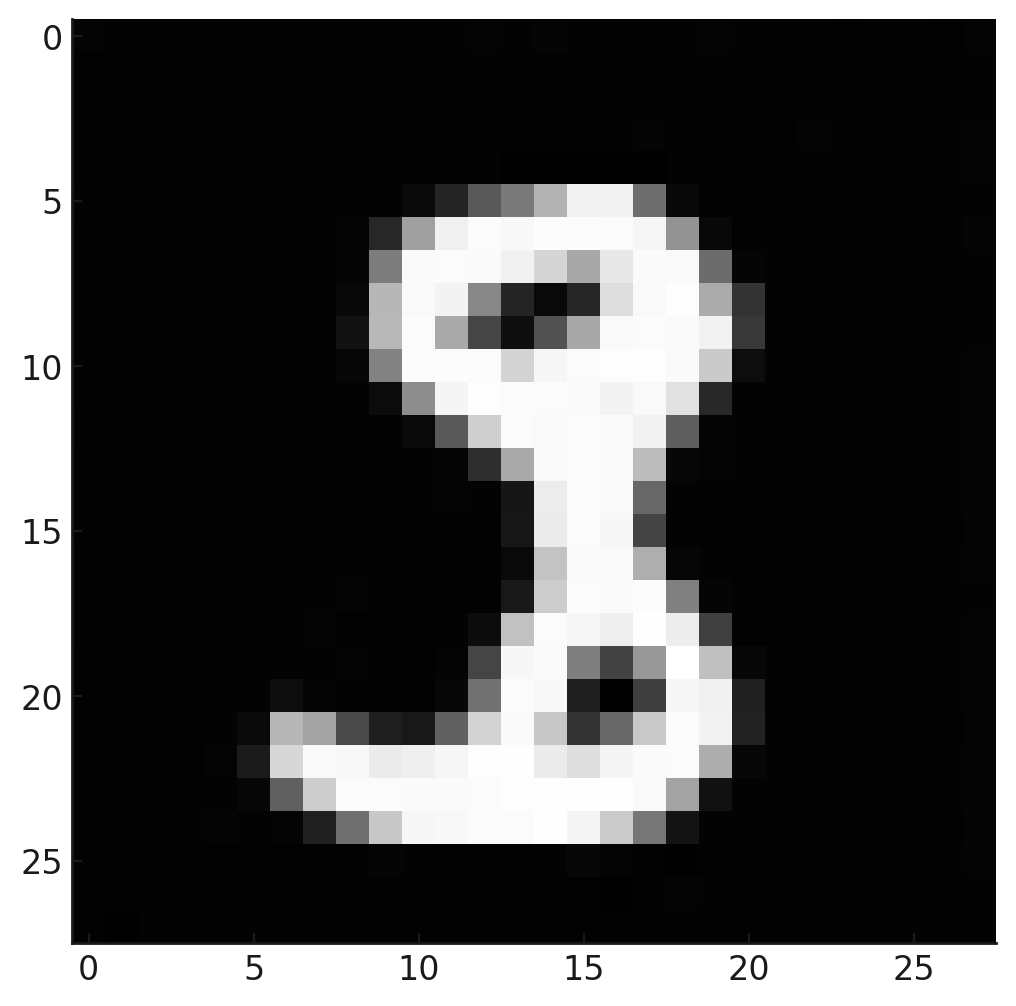

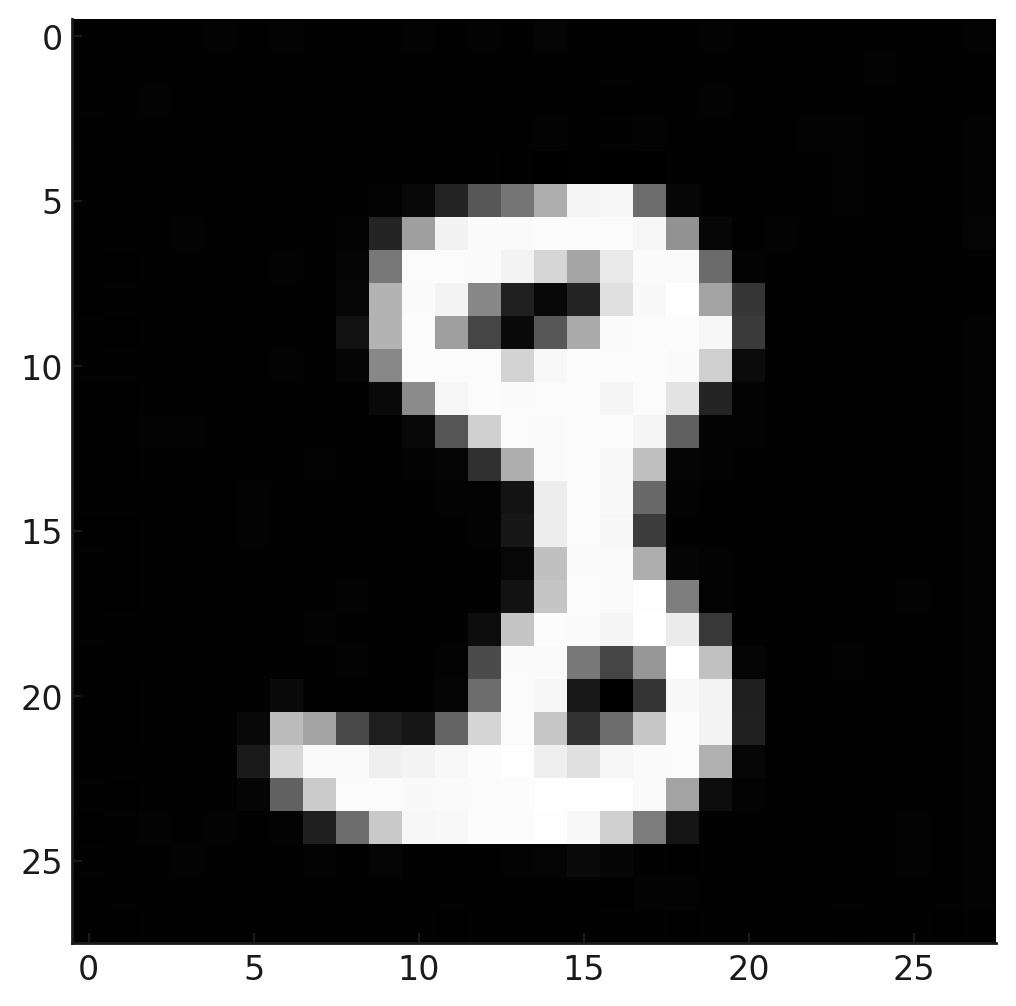

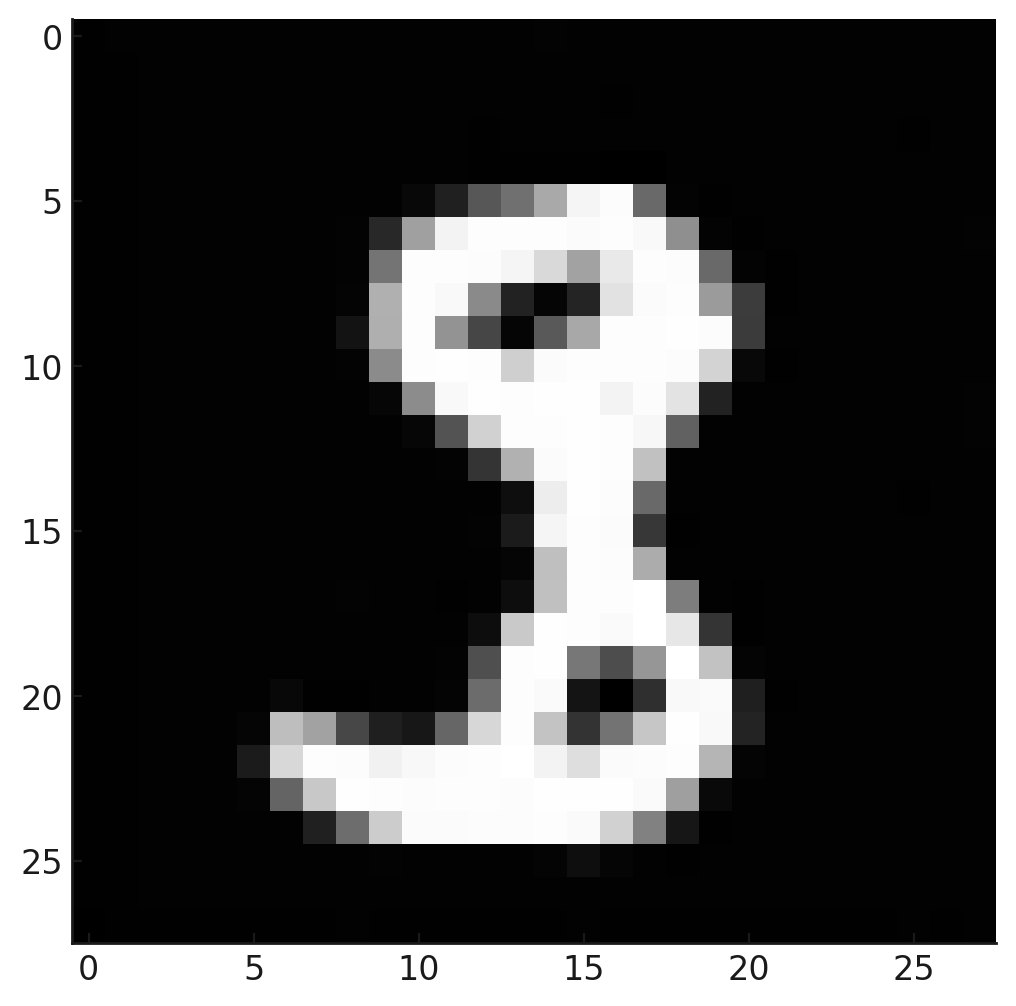

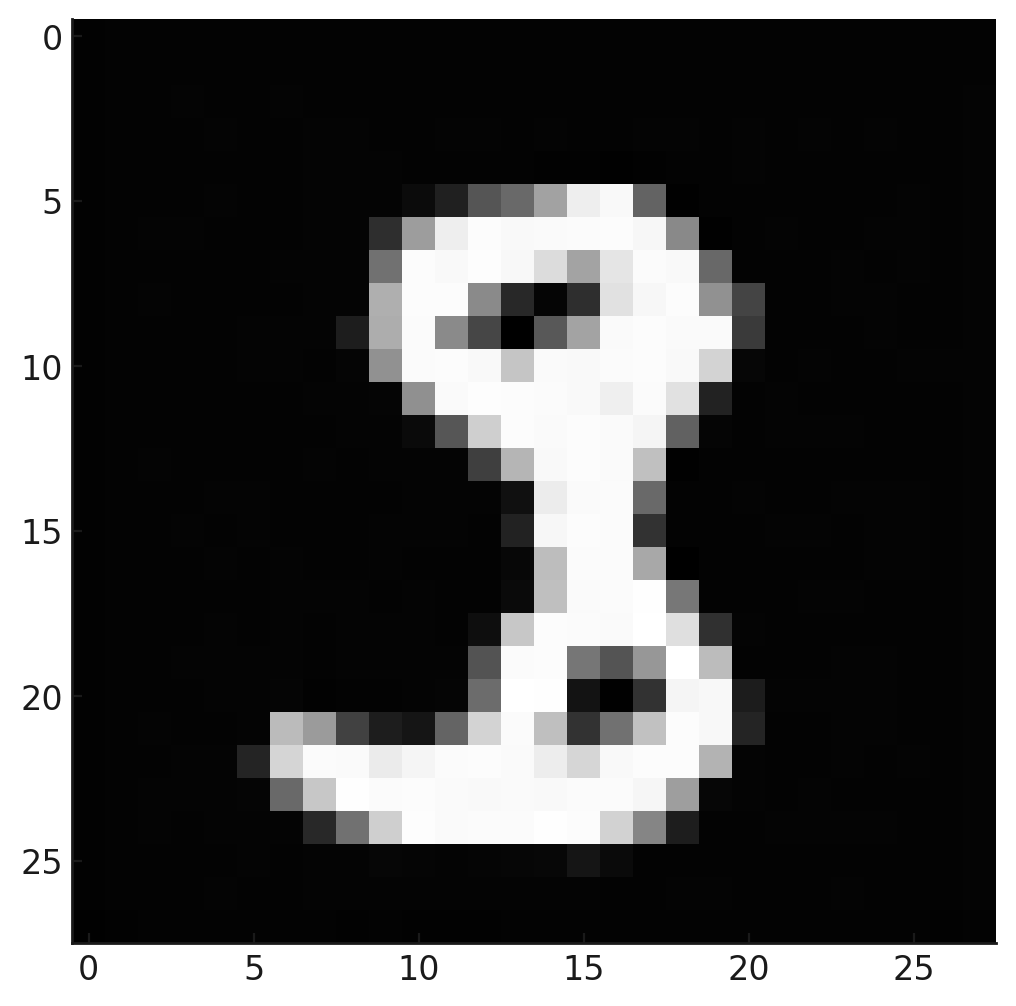

In [10]:
import io


with lmdb.open("../new_diffusion_distillation/data/mnist_origin_debug/uniform/lmdb", readonly=True) as env:
    with env.begin(write=False) as txn:
        raw = txn.get(f'0'.encode())
        buffer = io.BytesIO(raw)
        val = np.load(buffer)
        print(val.shape)
        extracted_val = extract(value=val)
        print(extracted_val.shape)
        for img in extracted_val:
            plt.imshow(img[0], cmap='gray')
            plt.grid(False)
            plt.show()
            # plt.imshow(img[1], cmap='gray')
            # plt.grid(False)
            # plt.show()
            # plt.imshow(img[2], cmap='gray')
            # plt.grid(False)
            # plt.show()
            # plt.imshow(img[3], cmap='gray')
            # plt.grid(False)
            # plt.show()
        # print(np.frombuffer(raw, dtype=np.uint8).reshape(-1, 28, 28))

In [ ]:
class MNISTData(Dataset):
    def __init__(self, path, data_shape, dims, t_idx=None, num_data=None):
        super().__init__()
        env = lmdb.open(path, max_readers=32, 
                        readonly=True, readahead=False, 
                        lock=False, meminit=False)

        self.t_idx = t_idx
        self.dims = dims
        if num_data:
            self.length = num_data
        else:
            with env.begin(write=False) as txn:
                self.length = int(str(txn.get('length'.encode()), 'utf-8'))
        # print(self.length)
        env.close()
        self.shape = data_shape
        if t_idx:
            self.use_idx = True
        else:
            self.use_idx = False
        self.path = path
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        if not hasattr(self, 'txn'):
            self.open_db()

        key = f'{index}'.encode()
        value = self.txn.get(key)
        val = np.frombuffer(value, dtype=np.float32)
        extracted_val = self.extract(val)
        data = torch.from_numpy(extracted_val)
        return data

    def extract(self, value):
        # print(value.shape)
        data = value.reshape(self.shape)
        data = data.transpose(self.dims)
        if self.use_idx:
            data = data[self.t_idx]
        return data
    def open_db(self):
        self.env = lmdb.open(self.path, max_readers=32, 
                        readonly=True, readahead=False, 
                        lock=False, meminit=False)
        self.txn = self.env.begin(write=False, buffers=True)